# Properties Iterator

## Description

This notebook file takes various combinations of properties and iterates over them to find combinations that result in the smallest radius in the SOM for a given set of items.


## Workflow

 1. Select the properties you want to iterate over in [the column selection cell](#column_selection_cell).
     1. The `fixed_columns` will be used in all combinations to be iterated over. Properties in here do not substantially increase the completion time.
     1. The `varying_coluns` will be used for all combinations of inclusion and non-inclusion. Each property in here doubles the completion time.
 1. Modify [the som training cell](#som_training_cell) as appropriate to include whatever data you feel will be useful in the radius dataframe.
 1. Inspect the table of lo/hi radii in [the radius dataframe cell](#radius_dataframe_cell).
 1. If you want to look at a particular cluster map closely, you can use the `cluster_tabs` function to view an individual SOM closely.

In [ ]:
from typing import List

In [ ]:
import numpy as np
import pandas as pd
import logging
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

In [ ]:
from sompy.sompy import SOMFactory

In [ ]:
import Parse_SOM
from tfprop_sompy.utils.data import calculate_SOM_radius, calculate_cluster_spread
from tfprop_sompy.jupyter_integration.cluster_inspector import make_cluster_graph, kmeans_clust, sort_materials_by_cluster, cluster_tabs

from tfprop_sompy.tfprop_vis import render_cluster_borders_to_axes, dataframe_to_coords, render_points_to_axes
from tfprop_sompy.vis.som import plot_material_categories

In [ ]:
logging.getLogger().setLevel(logging.WARNING)

In [ ]:
fin = 'data/Updated_PCM.csv'

In [ ]:
mapsize = (50, 50)
n_job = 4
mats_data_df = Parse_SOM.properties_dataframe_from_file(fin)

In [ ]:
# Replace spaces in the column names with underscores so they play nice with pandas
mats_data_df.columns = (*map(lambda x: x.replace(' ', '_'), mats_data_df.columns), )

In [ ]:
# This is just for reference, these are all the non-computed properties.

som_columns = [*map(lambda a: a.replace(' ', '_'), (x for x in Parse_SOM.COLUMN_NAMES if x != "Material family"
                     and x not in Parse_SOM.BAD_PROPERTIES))]

original_columns = ['Youngs_modulus',
 'Yield_strength',
 'Tensile_strength',
 'Compressive_strength',
 'Flexural_modulus',
 'Flexural_strength',
 'Shear_modulus',
 'Bulk_modulus',
 'Poisson_ratio',
 'Fatigue_strength',
 'Fracture_toughness',
 'Melting_point',
 'Max_service_temp',
 'Min_service_temp',
 'Thermal_conductivity',
 'Specific_heat_capacity',
 'Thermal_expansion_coefficient',
 'Latent_heat_of_fusion',
 'Electrical_resistivity',
 'Electrical_conductivity',
 'Galvanic_potential',
 'Mechanical_loss_coefficient']

In [ ]:
for a in original_columns:
    print(a.replace('_', ' '))

In [ ]:
# This cell handles bucketing based off the quartile of LHoF
mats_data_df = mats_data_df.assign(
    lhof_bucket=pd.qcut(mats_data_df['Latent_heat_of_fusion'], [0,.10,.9,1.], labels=["Low", "Medium", "High"])
)

In [ ]:
# Filter out carbon fibers/etc.
mats_data_df = mats_data_df[mats_data_df.Latent_heat_of_fusion < 2000]

In [ ]:
len(mats_data_df)

<a id="column_selection_cell"/>

In [ ]:
NUM_CLUSTERS = 12

# Remove columns from here once you've either found them to be useless
# Or a definite "In" - put the ones you're keeping in "fixed_columns"
varying_columns = [
#     'Poisson_ratio',
#     'Specific_heat_capacity',
    'Youngs_modulus',
    'Electrical_conductivity',
    'Thermal_conductivity',
    'Fracture_toughness',
    'Fatigue_strength'
]

# Place columns you've made a definite decision on including here
fixed_columns = [
    'Poisson_ratio',
    'Specific_heat_capacity',
    'Melting_point',
    'Flexural_strength',
 ]

In [ ]:
# Drop materials that don't have these properties
# mats_data_df.dropna(subset=varying_columns+fixed_columns, inplace=True)
mats_data_df.dropna(subset=som_columns, inplace=True)

In [ ]:
# Fill in good PCM names here
high_lhof_list = mats_data_df[lambda x: x.lhof_bucket == "High"].index
low_lhof_list = mats_data_df[lambda x: x.lhof_bucket == "Low"].index

In [ ]:
def powerset(iterable, min_items=0):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(min_items, len(s)+1))

In [ ]:
# Add the fixed columns to every iterated set
minimum_items = max(2 - len(fixed_columns), 0)
column_set_iterator = map(lambda x: fixed_columns + list(iter(x)), powerset(varying_columns, minimum_items))

<a id="som_training_cell"/>

In [ ]:
def train_single_som(column_set: List[str]):
    descr = mats_data_df[column_set].values
    
    sm = SOMFactory.build(descr, mapsize=mapsize, normalization='var', 
                          initialization='pca', component_names=column_set)
    # This will take some time
    sm.train(n_job=n_job, train_rough_len=0, train_finetune_len=0)
    
    cl_labels = kmeans_clust(sm, NUM_CLUSTERS)
    hi_cluster_spread = calculate_cluster_spread(mats_data_df, high_lhof_list, sm, cl_labels)

    hi_som_radius, hi_som_centroid = calculate_SOM_radius(mats_data_df, high_lhof_list, sm)
    
    lo_cluster_spread = calculate_cluster_spread(mats_data_df, low_lhof_list, sm, cl_labels)

    lo_som_radius, lo_som_centroid = calculate_SOM_radius(mats_data_df, low_lhof_list, sm)
    
    return hi_som_radius, hi_som_centroid, hi_cluster_spread, \
            lo_som_radius, lo_som_centroid, lo_cluster_spread, \
            len(column_set), \
            sm, cl_labels

In [ ]:
radius_df = pd.DataFrame(columns=['hi_SOM_radius', 'hi_SOM_centroid', 'hi_cluster_spread',
                                  'lo_SOM_radius', 'lo_SOM_centroid', 'lo_cluster_spread',
                                  'num_properties',
                                  'sm', 'cl_labels'])

for column_set in column_set_iterator:
    descr = mats_data_df[column_set].values
    display(descr.shape)
    display(column_set)
    
    radius_df.loc[", ".join(column_set)] = train_single_som(column_set)
    

In [ ]:
radius_df.loc[", ".join(som_columns)] = train_single_som(som_columns)

In [ ]:
all_cols_wo_tc = [a for a in som_columns if a != "Thermal_conductivity"]
radius_df.loc[", ".join(all_cols_wo_tc)] = train_single_som(all_cols_wo_tc)

<a id="radius_dataframe_cell"/>

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

sorted_rdf = radius_df[['hi_SOM_radius', 'hi_cluster_spread', 'lo_SOM_radius', 'lo_cluster_spread', 'num_properties']].sort_values(by=["hi_SOM_radius"])
sorted_rdf

In [ ]:
sorted_rdf.sort_values(by='lo_SOM_radius')

In [ ]:
from importlib import reload
from tfprop_sompy.vis import som
reload(som)
from tfprop_sompy.vis.som import plot_material_categories
None

In [ ]:
for a in mats_data_df['Material_family'].unique():
    family_df = mats_data_df[mats_data_df.Material_family == a]
    print(f"{a}\t{len(family_df)}\t{100*len(family_df) / len(mats_data_df):.2f}%")

In [ ]:
scatterplot_styles = {
    'Ceramic (non-technical)': {
        'marker': '+'
    },
    'Metal (non-ferrous)': {
        'marker': 'x'
    },
    'Ceramic (technical)': {
        'marker': 'o'
    },
    'Metal (other)': {
        'marker': 's'
    },
    'Metal (ferrous)': {
        'marker': '*'
    },
    'Metal (precious)': {
        'marker': '^'
    },
    'Plastic (thermoset)': {
        'marker': 'P'
    },
    'Plastic (thermoplastic, semi-crystalline)': {
        'marker': 'D'
    }
}

In [ ]:
def my_points_renderer(ax, coord, data, p_cmap='hot', p_marker='o'):
    stats = data.describe()
    color_percentile = (data.values - stats['min']) / (stats['max'] - stats['min'])
    my_norm = mpl.colors.Normalize(vmin=stats['min'], vmax=stats['max'])
    my_scatter = ax.scatter(coord[:, 0]+0.5, coord[:, 1]+0.5, c=color_percentile, cmap=p_cmap, marker=p_marker)
    return my_scatter, my_norm

In [ ]:
def draw_som_plots(sm, cl_labels):
    fig_extrema, ax_extrema = make_cluster_graph(sm, cl_labels, p_cmap='Greys', do_colorbar=False)
    ax_extrema.axis('equal')
    fig_extrema.set_size_inches(10, 5)
    high_coords = dataframe_to_coords(sm, mats_data_df.loc[high_lhof_list])[:, 0:2]
    hi_scatter, hi_norm = my_points_renderer(ax_extrema, high_coords, (mats_data_df.loc[high_lhof_list])['Latent_heat_of_fusion'])
    fig_extrema.colorbar(plt.cm.ScalarMappable(cmap='hot', norm=hi_norm)).set_label("Top 10th %ile")
    
    low_coords = dataframe_to_coords(sm, mats_data_df.loc[low_lhof_list])[:, 0:2]
    lo_scatter, lo_norm = my_points_renderer(ax_extrema, low_coords, (mats_data_df.loc[low_lhof_list])['Latent_heat_of_fusion'], p_cmap='winter', p_marker='+')
    fig_extrema.colorbar(plt.cm.ScalarMappable(cmap='winter', norm=lo_norm)).set_label("Bottom 10th %ile")
    plt.show(fig_extrema)
    
    fig_families, ax_families = make_cluster_graph(sm, cl_labels, p_cmap='Greys', do_colorbar=False)
    ax_families.axis('equal')
    fig_families.set_size_inches(15, 5)
    
    family_scatters, family_legends = plot_material_categories(sm, mats_data_df, 'Material_family', scatterplot_styles, ax_families, cmap="tab20")
    famleg_lines = map(lambda x: x[0], family_legends)
    famleg_labels = map(lambda x: x[1], family_legends)
    ax_families.legend(famleg_lines, famleg_labels)
    plt.show(fig_families)

In [ ]:
%matplotlib inline
for i, n in radius_df.sort_values(by=["lo_SOM_radius"]).iterrows():
    display(n.name)
    draw_som_plots(n.sm, n.cl_labels)

In [ ]:
# Best low cluster spread
entry_of_interest = radius_df.loc['Poisson_ratio, Specific_heat_capacity, Melting_point, Flexural_strength, Youngs_modulus, Fracture_toughness, Fatigue_strength']
draw_som_plots(entry_of_interest.sm, entry_of_interest.cl_labels)

In [ ]:
# Best low SOM radius
entry_of_interest = radius_df.loc['Poisson_ratio, Specific_heat_capacity, Melting_point, Flexural_strength, Youngs_modulus, Electrical_conductivity, Thermal_conductivity']
draw_som_plots(entry_of_interest.sm, entry_of_interest.cl_labels)

In [ ]:
# This makes it so it will display the full lists
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [ ]:
pd.DataFrame.from_dict({'latent_heat_of_fusion': mats_data_df.loc[low_lhof_list]["Latent_heat_of_fusion"].sort_values(), 'material_family': mats_data_df.loc[low_lhof_list]["Material_family"] })

In [ ]:
pd.DataFrame.from_dict({'latent_heat_of_fusion': mats_data_df.loc[high_lhof_list]["Latent_heat_of_fusion"].sort_values(), 'material_family': mats_data_df.loc[high_lhof_list]["Material_family"].sort_values() })

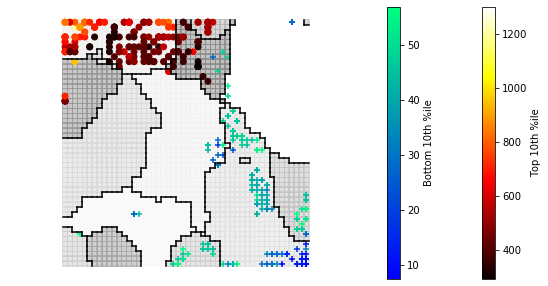

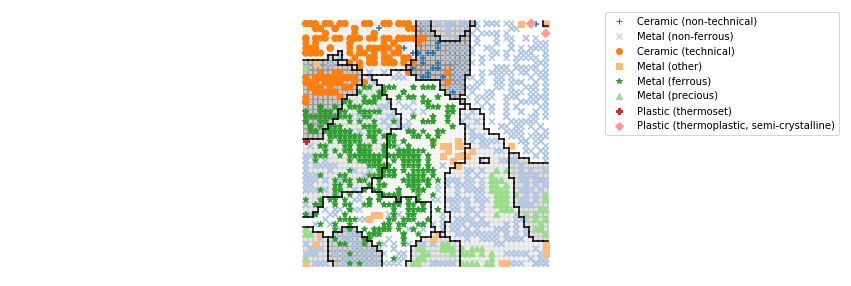

In [ ]:
my_entry = radius_df.sort_values(by=["hi_SOM_radius"]).iloc[0]
clusters_list = sort_materials_by_cluster(my_entry.sm, mats_data_df, my_entry.cl_labels)

cluster_tabs(my_entry.sm, mats_data_df, clusters_list, my_entry.cl_labels)

# Methods of modifying generated SOM

 - Change seed used for the PCA initialization
 - Change order of items given to SOM for training

In [ ]:
interesting_sets = [
    (['Melting_point', 'Fracture_toughness', 'Flexural_strength'], 34.455), # Best SOM_radius for top 15th %ile (34.455)
    (['Melting_point', 'Fracture_toughness', 'Flexural_strength', 'Electrical_conductivity', 'Fatigue_strength'], 32.512), # Added a couple more parameters for lower radius (32.512)
    (['Melting_point', 'Fracture_toughness', 'Flexural_strength', 'Youngs_modulus', 'Electrical_conductivity', 'Fatigue_strength'], 31.511), # The prior one gets a smaller radius when trained with Youngs modulus (31.511)
    (['Melting_point', 'Fracture_toughness', 'Flexural_strength', 'Youngs_modulus'], 39.451), # But on its own it makes the radius much worse (39.451)
    (['Poisson_ratio', 'Specific_heat_capacity', 'Melting_point', 'Fracture_toughness', 'Flexural_strength', 'Fatigue_strength'], 33.094), # 33.094004
    (['Poisson_ratio', 'Specific_heat_capacity', 'Melting_point', 'Fracture_toughness', 'Flexural_strength'], 41.707), # 41.707067 - Fatigue strength seems to provide a lot more focus here?
    (['Poisson_ratio', 'Specific_heat_capacity', 'Melting_point', 'Fracture_toughness', 'Flexural_strength', 'Thermal_conductivity', 'Fatigue_strength'], 39.936), # 39.936320 - Conductivity appears to be a "distractor term"
]

In [ ]:
import functools

In [ ]:
unique_props = functools.reduce(lambda a, b: a.union(b[0]), interesting_sets, set())

In [ ]:
set_df = pd.DataFrame(columns=[*unique_props, 'SOM_radius'])
for i, x in enumerate(interesting_sets):
    properties_used = []
    for y in unique_props:
        if y in x[0]:
            properties_used.append('x')
        else:
            properties_used.append(' ')
    properties_used.append(x[1])
    set_df.loc[i] = properties_used

set_df.sort_values(by='SOM_radius', inplace=True)
set_df.index = range(len(set_df))

set_df.style.where(lambda x: x == 'x', 'background-color: green; color: green').where(lambda x: type(x) == str and x != 'x', 'background-color: red').map(lambda x: 'border-color:black; border-width:1px')